# Summary Stats for Vandalism and Topic Prediction on Processed AFT Dataset
**Author:** Jim Maddock

**Last Updated:** 5-29-20

**Description:** Summary stats for the processed AFT Dataset.  Currently ***preliminary*** stats due to processing errors.  This notebook should:
* Vandalism
    * determine distribution of vandalism classifications
    * compare vandalism classifications to helpful/unhelpful classes
* Determine distribution of topic classes

In [21]:
import pandas as pd
import numpy as np
import uuid
import logging
import os
import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

In [62]:
pd.set_option("display.min_rows", 100)
pd.set_option("display.max_rows", 100)

In [28]:
# import dataset from csv
BASE_FILE_PATH = '/srv/aft/processed/chunks/'

dtypes = {
    'aft_id':object
}

file_list = os.listdir(BASE_FILE_PATH)
processed_df = pd.DataFrame()
for file in file_list:
    file_path = os.path.join(BASE_FILE_PATH,file)
    chunk = pd.read_csv(file_path,escapechar='\\', encoding='latin-1', dtype=dtypes)
    processed_df = processed_df.append(chunk)


In [29]:
processed_df['sign_helpful'] = processed_df['aft_net_helpful'].apply(np.sign)

### Vanalism Prediction
As we can see, we classify 82% of the dataset as vandalism, compared to just 5% as ok.  This could mean:
1. The dataset is mostly vandalism
1. The classifier is over-predicting vandalism

In [7]:
counts = processed_df.groupby('dq_pred').size().to_frame('count').sort_values('count')
counts['percent'] = counts['count'].divide(counts['count'].sum())
counts

,count,percent
dq_pred,,
attack,4438,0.040146
OK,6314,0.057116
spam,8451,0.076448
vandalism,91343,0.826290


If we look at the labelled data, about 39% was labelled as "useful", which is presumably not vandalism

In [58]:
counts = processed_df.groupby('sign_helpful').size().to_frame('count').sort_values('count')
counts['percent'] = counts['count'].divide(counts['count'].sum())
counts

,count,percent
sign_helpful,,
0.0,9224,0.080235
1.0,44908,0.390630
-1.0,60831,0.529135


If #1 were correct, we would expect that most of the predicted vandalism would also be marked as unhelpful.  However, 31% of the vandalism is "helpful", while 44% is unhelpful.  Likewise, 2% of the OK predictions were helpful and 2% were unhelpful.

In [11]:
counts = processed_df.groupby(['dq_pred','sign_helpful']).size().to_frame('count').sort_values('count')
counts['percent'] = counts['count'].divide(counts['count'].sum())
counts.reset_index().sort_values(['dq_pred','sign_helpful'])

,dq_pred,sign_helpful,count,percent
5,OK,-1.0,2852,0.025799
1,OK,0.0,505,0.004568
6,OK,1.0,2957,0.026749
4,attack,-1.0,2575,0.023293
0,attack,0.0,347,0.003139
3,attack,1.0,1516,0.013714
7,spam,-1.0,3720,0.033651
2,spam,0.0,686,0.006206
8,spam,1.0,4045,0.036591
11,vandalism,-1.0,49297,0.445941


confusion matrix, precision, recall, and f1-score for our vandalism predictions.  This assumes that all unhelpful feedback will be flagged as vandalism, attack, or spam (**TRUE**), and all helpful or neutral feedback will be predicted "OK" or None (**FALSE**).

**True** = helpful + neutral = OK   
**False** = unhelpful = attack + spam + vandalism

In [61]:
def transform_dq_pred(x):
    dq_pred_pos = ['OK']
    dq_pred_neg = ['attack','spam','vandalism']
    
    if x in dq_pred_pos:
        return False
    
    elif x in dq_pred_neg:
        return True
    
def transform_sign_helpful(x):
    if x >= 0:
        return False
    else:
        return True
    

# True = helpful + neutral = OK
# False = unhelpful = attack + spam + vandalism

counts = pd.DataFrame()
counts['dq_pred'] = processed_df['dq_pred'].apply(transform_dq_pred)
counts['dq_pred'] = counts['dq_pred'].fillna(True)
counts['sign_helpful'] = processed_df['sign_helpful'].apply(transform_sign_helpful)

print(confusion_matrix(counts['sign_helpful'].values, counts['dq_pred'].values))
print()
print(classification_report(counts['sign_helpful'].values, counts['dq_pred'].values))

[[ 3462 50670]
 [ 2852 57999]]

              precision    recall  f1-score   support

       False       0.55      0.06      0.11     54132
        True       0.53      0.95      0.68     60851

   micro avg       0.53      0.53      0.53    114983
   macro avg       0.54      0.51      0.40    114983
weighted avg       0.54      0.53      0.42    114983



In [31]:
SAMPLE_SIZE = 100
OUTPUT_FILE = '/srv/aft/processed/samples/vandalism_check_5-8-20.csv'

def createVandalismSample(df, sample_size, output_file):
    cols = ['UUID','sign_helpful','dq_pred','aft_comment','dq_prob_OK','dq_prob_attack','dq_prob_spam','dq_prob_vandalism']
    sample_df = processed_df.groupby(['dq_pred','sign_helpful']).apply(lambda x: x.sample(sample_size))
    sample_df = sample_df[cols]
    sample_df.to_csv(output_file,index=False)
    
createVandalismSample(processed_df, sample_size=SAMPLE_SIZE, output_file=OUTPUT_FILE)

### Topic

Topics seem to more or less follow a power law distribution.  Most topics have less than 700 comments (50th percentile), which is .6% of the total number of comments.  The largest topic has 19370 or 16.8 percent of the total comments.

In [63]:
processed_df.groupby('dt_pred').size().to_frame('count').sort_values('count')

,count
dt_pred,
"('Geography.Regions.Africa.Eastern Africa',)",1
"('Culture.Media.Video games',)",2
"('Geography.Regions.Asia.Central Asia',)",4
"('STEM.Technology',)",4
"('Geography.Regions.Asia.South Asia',)",8
"('Geography.Regions.Europe.Western Europe',)",11
"('Geography.Regions.Africa.Western Africa',)",12
"('Geography.Regions.Asia.West Asia',)",13
"('Geography.Regions.Asia.Southeast Asia',)",15


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3f5d4c1240>]],
      dtype=object)

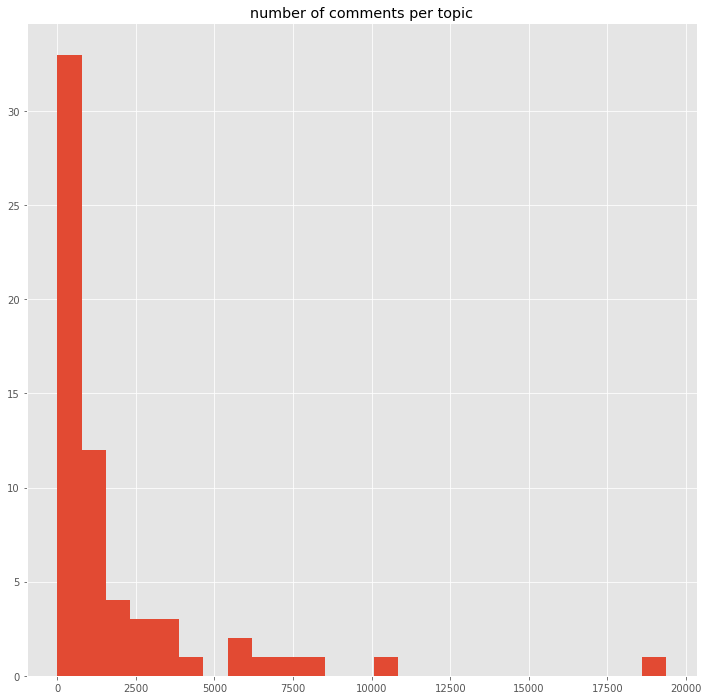

In [64]:
processed_df.groupby('dt_pred').size().to_frame('number of comments per topic').hist(bins=25,figsize=(12,12))

In [15]:
processed_df.groupby('dt_pred').size().quantile(np.arange(0,1,.1))

0.0       1.0
0.1      12.2
0.2      29.8
0.3      79.0
0.4     271.4
0.5     709.0
0.6    1097.4
0.7    1523.8
0.8    2502.8
0.9    5636.8
dtype: float64

When we only use top level categories, the distribution is still relatively unequal.  Culture recieves 53% of comments, STEM recieves 20% of comments, and History only recieves 5.8%

In [19]:
counts = processed_df['dt_pred'].apply(lambda x: str(x).replace('(\'','').split('.')[0]).to_frame('count').groupby('count').size().to_frame('count')
counts['percent'] = counts['count'].divide(counts['count'].sum())
counts

,count,percent
count,,
Culture,61782,0.537314
Geography,20760,0.180548
History and Society,6755,0.058748
STEM,23131,0.201169
nan,2555,0.022221
